In [1]:
import os


In [2]:
import numpy as np
from pydrake.all import (HPolyhedron, VPolytope, Hyperellipsoid, MathematicalProgram, le, Solve, eq)
from cspace_utils.plotting import plot_hpoly_matplotlib, plot_ellipse, plot_hpoly_skeleton_matplotlib
import matplotlib.pyplot as plt

In [3]:
N = 10 

np.random.seed(15)
cov = np.array([[1, 0.5], [0.5, 2]])
pts = (cov@np.random.randn(N,2).T).T
vpoly_min =VPolytope(pts.T).GetMinimalRepresentation()
hpoly = HPolyhedron(vpoly_min)
he = Hyperellipsoid(np.linalg.inv(cov), np.zeros(2))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-11


In [4]:
from pydrake.all import MathematicalProgram, Solve
def solve_projection(pt :np.ndarray, hpoly: HPolyhedron):
    dim = len(pt)
    assert hpoly.ambient_dimension() == dim
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(dim)
    quad_cost = ((x.reshape(-1,1)-pt.reshape(-1,1)).T@(x.reshape(-1,1)-pt.reshape(-1,1)))[0,0]
    prog.AddQuadraticCost(quad_cost)
    hpoly.AddPointInSetConstraints(prog, x)
    result = Solve(prog)
    if result.is_success():
        return result.GetSolution(x), np.sqrt(result.get_optimal_cost())
    else: 
        return None
    
def distance(pt, hpoly):
    pt_proj, dist = solve_projection(pt, hpoly)
    return dist-0.01

def get_closest_point(pt, hpoly):
    pt_proj, dist = solve_projection(pt, hpoly)
    return pt_proj

def plot_distance_fn(ax, 
                     hpoly,
                     Z = None, 
                     xrange = [-5,5], 
                     yrange= [-5,5], 
                     resolution = 0.5,
                     linewidth = 1,
                     zorder = 0):
    
    x = np.arange(xrange[0], xrange[1], resolution)
    y = np.arange(yrange[0], yrange[1], resolution)
    X,Y = np.meshgrid(x,y)
    if Z is not None:
        CS = ax.contour(X, Y, Z,[1, 2], linewidths = linewidth,zorder = zorder, colors = ['r', 'b'])
    else:
        Z = np.zeros_like(X)
        for i in  range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i,j] = distance(np.array([X[i,j], Y[i,j]]), hpoly)
        CS = ax.contour(X, Y, Z,[ 1, 2], linewidths = linewidth,zorder = zorder, colors = ['r', 'b'])
    return Z

def plot_distance_poly(ax, 
                     eval_poly,
                     xrange = [-6,6], 
                     yrange= [-6,6], 
                     resolution = 0.5,
                     linewidth = 1,
                     zorder = 0):

    x = np.arange(xrange[0], xrange[1], resolution)
    y = np.arange(yrange[0], yrange[1], resolution)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    for i in  range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = eval_poly(np.array([X[i,j], Y[i,j]]))
    CS = ax.contour(X, Y, Z,np.linspace(0.0, 2, num= 10), linewidths = linewidth,zorder = zorder)
    return Z
    # for xr,yr, zr in zip(X,Y,Z):
    #     for x,y in zip(xr, zr, )
    #     print(x,y) 
    # #


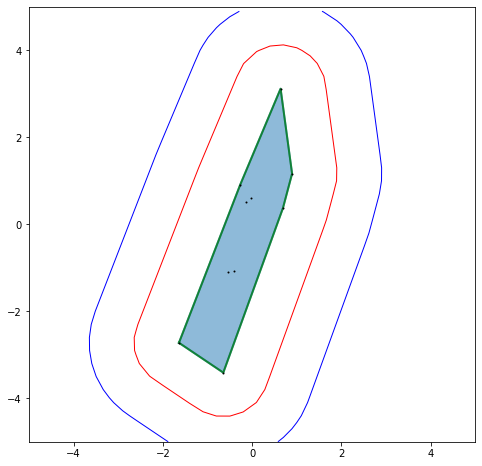

In [5]:
fig, ax = plt.subplots(figsize = (8,8))
#ax.axis('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plot_hpoly_matplotlib(ax, hpoly)
plot_hpoly_skeleton_matplotlib(ax, hpoly, 'g')
#plot_ellipse(ax, he)
pt = np.array([0,3])
pt_proj = get_closest_point(pt, hpoly)
c = np.array([pt.T, pt_proj.T])
Z = plot_distance_fn(ax, hpoly, resolution=0.3)
plt.scatter(pts[:,0], pts[:,1], s =1, c = 'k')

points_on_boundary = vpoly_min.vertices().T

In [13]:
from cspace_utils.geometry import polynomial_distance_function_approx

poly, eval_poly, supppts = polynomial_distance_function_approx(vpoly_min, degree=2, eval_factor=10)

number of eval points 60
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 123             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 126             
  Matrix variables       : 1 (scalarized: 3)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 60
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1   

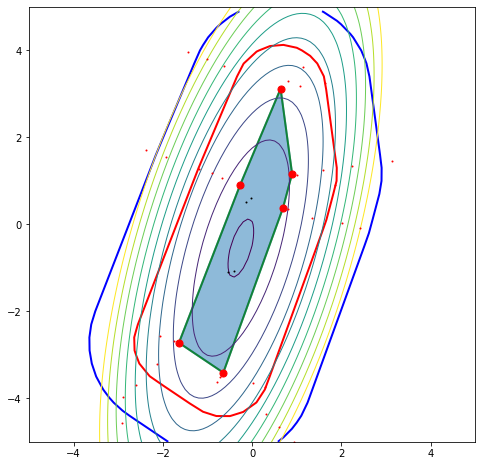

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
#ax.axis('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plot_hpoly_matplotlib(ax, hpoly)
plot_hpoly_skeleton_matplotlib(ax, hpoly, 'g')
#plot_ellipse(ax, he)
pt = np.array([0,3])
pt_proj = get_closest_point(pt, hpoly)
dir = np.array([pt.T, pt_proj.T])
Z = plot_distance_fn(ax, hpoly, Z, resolution=0.3, linewidth=2)
#plt.plot(dir[:,0], dir[:,1])
ell = Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(points_on_boundary.T)
#plot_ellipse(ax, ell, linewidth=1, color= 'k')
ell2 = Hyperellipsoid(A = ell.A()*0.5, center = ell.center())
#plot_ellipse(ax, ell2, linewidth=1, color = 'k')
plt.scatter(pts[:,0], pts[:,1], s =1, c = 'k')
Z_poly = plot_distance_poly(ax, eval_poly, resolution=0.1)
#supppts, dists =get_supporting_points(points_on_boundary, distances = distances)
ax.scatter(supppts[:, 0], supppts[:, 1], s=1, c = 'r')
ax.scatter(points_on_boundary[:, 0], points_on_boundary[:, 1], s=50, c = 'r')
points_on_boundary = vpoly_min.vertices().T

In [ ]:
N = 400 

np.random.seed(15)
pts = (np.random.randn(N,14).T).T
vpoly_min =VPolytope(pts.T).GetMinimalRepresentation()
from cspace_utils.geometry import polynomial_distance_function_approx


In [20]:

poly, eval_poly, supppts = polynomial_distance_function_approx(vpoly_min, degree=4, eval_factor=3)

number of eval points 984


In [52]:
def get_supporting_plane(pt, verts, randomize=False):
    dim = len(pt)
    prog = MathematicalProgram()
    b = prog.NewContinuousVariables(1, 'b')
    a = prog.NewContinuousVariables(dim, 'a')
    if randomize:
        rand = 2*(np.random.rand(dim)-0.5)*0.1*np.linalg.norm(pt) 
    else:
        rand = pt
    cost = - a.T@(rand) 
    prog.AddBoundingBoxConstraint( np.array(dim*[-1]),  np.array(dim*[1]), a)
    for v in points_on_boundary:
        prog.AddLinearConstraint(le(a.T@v +b, 0))
    prog.AddLinearConstraint(eq(a.T@pt + b, 0))
    prog.AddLinearCost(cost)

    result= Solve(prog)
    if result.is_success():
        return result.GetSolution(a), result.GetSolution(b)
    
def get_supporting_point_direction(pt, verts, randomize =False):
    a, b = get_supporting_plane(pt, verts, randomize)
    a_norm = a/(np.linalg.norm(a)+1e-6)
    return a_norm

def get_supporting_points(verts, distances = [1], randomize=True):
    pts=[]
    distances_pts =[] 
    for pt in verts:
        for d in distances:
            dir = get_supporting_point_direction(pt, verts, randomize=randomize)
            pts.append(pt + d*dir)
            distances_pts.append(d)
    return np.array(pts), np.array(distances_pts)
# def get_supporting_points(verts, distances= [1]):

#     pts=[]
#     distances_pts =[]
#     for v in verts:
#         dir = get_supporting_point_direction(v, verts)
#         for d in distances:
#             pts.append(v + d*dir)
#             distances_pts.append(d)
#     return np.array(pts), np.array(distances_pts)

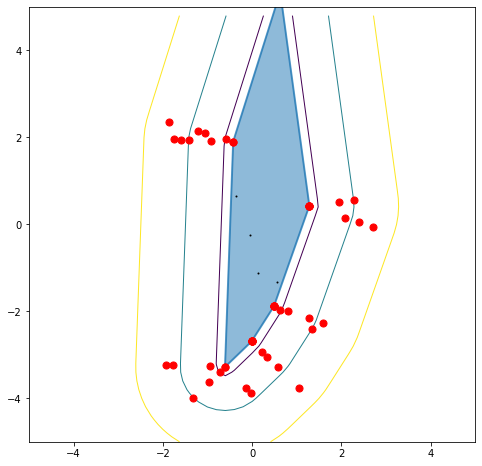

In [53]:
fig, ax = plt.subplots(figsize = (8,8))
#ax.axis('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plot_hpoly_matplotlib(ax, hpoly)
#plot_ellipse(ax, he)
pt = np.array([0,3])
pt_proj = get_closest_point(pt, hpoly)
dir = np.array([pt.T, pt_proj.T])
Z = plot_distance_fn(ax, hpoly, Z, resolution=0.2)
#plt.plot(dir[:,0], dir[:,1])
plt.scatter(pts[:,0], pts[:,1], s =1, c = 'k')
#plot_distance_poly(ax, ev_hand)
supppts, distances = get_supporting_points(points_on_boundary, distances = np.linspace(0,1.5, num= 10))
ax.scatter(supppts[:, 0], supppts[:, 1], s=50, c = 'r')
points_on_boundary = vpoly_min.vertices().T

In [54]:
import pydrake.symbolic as sym
import numpy as np
from pydrake.all import MosekSolver, ge
def ComputeHessian(poly):
    x = np.array([x for x in poly.indeterminates()])
    jac = poly.Jacobian(x)
    H = np.array([component.Jacobian(x) for component in jac])
    return H

# You can pass auxillary indets if you have free indeterminates that you want to reuse
def AddMatrixSosConstraint(prog, M, auxiliary=None):
    assert M.shape[0] == M.shape[1]
    if auxiliary and auxiliary.shape[0] < M:
        raise ValueError("Auxiliary Indeterminates too small to add this constraint")
    elif auxiliary:
        auxiliary = auxiliary[: M.shape[0]]
    else:
        auxiliary = prog.NewIndeterminates(M.shape[0], "aux")

    aux_poly = auxiliary.T @ M @ auxiliary
    Q, lam = prog.AddSosConstraint(aux_poly)
    return aux_poly, Q, lam


def AddPolynomialIsSosConvexConstraint(prog, M, auxillary_indets=None):
    H = ComputeHessian(M)
    return AddMatrixSosConstraint(prog, H, auxillary_indets)

# def get_monomials(x, deg = 1):
#     dim = len(x)
#     monomials = []
#     for d in range(deg):
#         for c in range(dim):
# import itertools

# def generate_monomials(x, degree = 1):
#     monomials = []
#     monomial_hashes = set([])
#     for d in range(degree + 1):
#         for indices in itertools.product(range(len(x)), repeat=d):
#             monomial = 1
#             hash = 0
#             if len(indices):
#                 for i in list(indices):
#                     hash+=10**(i+1)
#                     monomial *= x[i]
#                 if hash not in monomial_hashes:
#                     monomials.append(monomial)
#                 monomial_hashes =monomial_hashes.union([hash])
                
#             else:
#                 monomials.append(1)
#     return monomials
prog = MathematicalProgram()
x = prog.NewIndeterminates(2, 'x')
p = prog.NewFreePolynomial(sym.Variables(x), deg=8, coeff_name="c")
# monomials = generate_monomials(x, degree = 4)
# c = prog.NewContinuousVariables(len(monomials), 'c')
# expr = 0
# for coef, m in zip(c, monomials):
#     expr+= coef*m
# p = sym.Polynomial(expr, indeterminates=[i for i in x])

H = ComputeHessian(p)
aux_poly, Q, lam = AddMatrixSosConstraint(prog, H)

def eval_poly_partial(point):
    (A, decision_vars, b) = p.EvaluateWithAffineCoefficients(np.array([v for v in p.indeterminates()]), point)
    return (A@decision_vars + b)[0], (A, decision_vars, b)

def eval_poly_full(point, coefs):
    (A, decision_vars, b) = p.EvaluateWithAffineCoefficients(np.array([v for v in p.indeterminates()]), point)
    return A@coefs + b

distances_required = int(10*len(p.decision_variables())/len(points_on_boundary)+0.5)
print(distances_required)
supppts, distances = get_supporting_points(points_on_boundary, distances = np.square(np.linspace(0,1.5, num= distances_required)),randomize = True)
cost = 0
A_stack = []
b_stack = []
for val, point in zip(distances, supppts):
    expr, (A, vars, b) = eval_poly_partial(point)
    # A_stack.append(A)
    # b_stack.append(b)
    t = prog.NewContinuousVariables(1,"t")
    # Anew = np.zeros((A.shape[0]+1, A.shape[1]+1))
    # Anew[0,1:] = A
    # bnew = np.array([b])
    #prog.AddLorentzConeConstraint(quadratic_expression= (A@vars+b-val)[0], linear_expression=t[0])
    #prog.AddLorentzConeConstraint(Anew, bnew,np.concatenate((t,vars), axis = 0) )
    prog.AddLinearConstraint(le(A@vars+b-val, t[0]))
    prog.AddLinearConstraint(ge(A@vars+b-val, -t[0]))
    # Q = np.zeros((A.shape[1]+1, A.shape[1]+1)) 
    # Q[:-1,:-1] = 2*A.T@A
    # Q+=  1e-3*np.eye(Q.shape[1])
    # bcat = np.zeros(A.shape[1] + 1)
    # bcat[:-1] = -2*(b-val).T@A
    # bcat[-1] = -1
    # c = np.array([(b-val).T@(b-val)])
    # prog.AddQuadraticAsRotatedLorentzConeConstraint(
    #     Q = Q, b =bcat, c = c, vars=np.concatenate((vars,t), axis=0)
    # )
    prog.AddLinearCost(t[0])
    #qc = prog.Add2NormSquaredCost(A=A, b=val-b, vars = vars)
    # Qtmp = qc.evaluator().Q()
    # qc.evaluator().UpdateCoefficients(Qtmp+np.diag(np.power(1e-2*np.random.randn(Qtmp.shape[0]),2)),
    #                                    qc.evaluator().b(),
    #                                      qc.evaluator().c(), True)
    #print(np.min(np.linalg.eigvalsh(qc.evaluator().Q())))
# prog.Add2NormSquaredCost(A=np.vstack(A_stack), b = val - np.array(b_stack).squeeze(), vars = vars)
solver = MosekSolver()
from pydrake.all import ChooseBestSolver
# id = ChooseBestSolver(prog)
# print(f" Best solver is {id.name()}")
result = solver.Solve(prog)
print(result.is_success())
# coef_sol = result.GetSolution(list(p.monomial_to_coefficient_map().values()))
result_poly = result.GetSolution(p)
def eval_poly(pt):
    return result_poly.Evaluate({v: pt[i] for i, v in enumerate(x)} )

75
False


In [55]:
len(p.decision_variables())

45

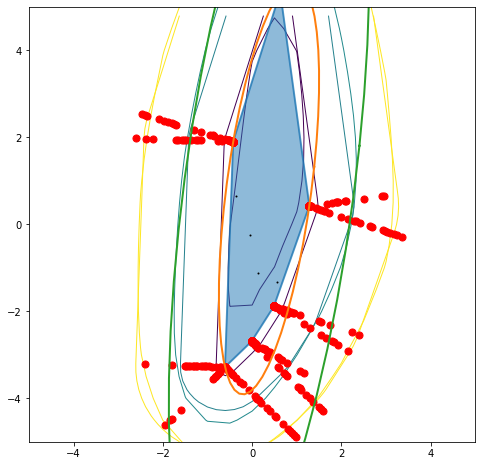

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
#ax.axis('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plot_hpoly_matplotlib(ax, hpoly)
#plot_ellipse(ax, he)
pt = np.array([0,3])
pt_proj = get_closest_point(pt, hpoly)
dir = np.array([pt.T, pt_proj.T])
Z = plot_distance_fn(ax, hpoly, Z, resolution=0.2)
#plt.plot(dir[:,0], dir[:,1])
ell = Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(points_on_boundary.T)
plot_ellipse(ax, ell, linewidth=2)
ell2 = Hyperellipsoid(A = ell.A()*0.5, center = ell.center())
plot_ellipse(ax, ell2, linewidth=2)
plt.scatter(pts[:,0], pts[:,1], s =1, c = 'k')
Z_poly = plot_distance_poly(ax, eval_poly)
#supppts, dists =get_supporting_points(points_on_boundary, distances = distances)
ax.scatter(supppts[:, 0], supppts[:, 1], s=50, c = 'r')
ax.scatter(points_on_boundary[:, 0], points_on_boundary[:, 1], s=50, c = 'r')
points_on_boundary = vpoly_min.vertices().T

In [241]:
# Z_poly

array([[2.00195025, 2.00174342, 2.00155745, 2.00139235, 2.00124811,
        2.00112473, 2.00102222, 2.00094057, 2.00087978, 2.00083985,
        2.00082078, 2.00082258, 2.00084524, 2.00088876, 2.00095315,
        2.0010384 , 2.00114451, 2.00127148, 2.00141932, 2.00158801,
        2.00177757, 2.001988  , 2.00221928, 2.00247143],
       [2.00181869, 2.00160786, 2.0014179 , 2.00124879, 2.00110055,
        2.00097318, 2.00086666, 2.00078101, 2.00071622, 2.00067229,
        2.00064923, 2.00064702, 2.00066568, 2.00070521, 2.00076559,
        2.00084684, 2.00094895, 2.00107192, 2.00121576, 2.00138046,
        2.00156602, 2.00177244, 2.00199973, 2.00224788],
       [2.00170232, 2.00148749, 2.00129352, 2.00112042, 2.00096818,
        2.0008368 , 2.00072629, 2.00063664, 2.00056785, 2.00051992,
        2.00049286, 2.00048666, 2.00050132, 2.00053684, 2.00059323,
        2.00067047, 2.00076858, 2.00088756, 2.00102739, 2.00118809,
        2.00136965, 2.00157208, 2.00179536, 2.00203951],
       [2.001

In [55]:

p.EvaluateIndeterminates(x, np.array([[0],[1]]))

RuntimeError: Polynomial::EvaluateIndeterminates: the coefficient c(0) is not a constant

In [21]:
def generate_monomials(n, d):
    monomials = []
    for degree in range(d + 1):
        for indices in itertools.product(range(n), repeat=degree):
            monomial = '*'.join(f'x_{index}' for index in indices)
            monomials.append(monomial)
    return monomials
generate_monomials(2, 2)

['', 'x_0', 'x_1', 'x_0*x_0', 'x_0*x_1', 'x_1*x_0', 'x_1*x_1']

In [35]:
a = set([2,3])

In [38]:
2 in a

True

In [18]:
def get_supporting_plane(pt, verts):
    dim = len(pt)
    prog = MathematicalProgram()
    b = prog.NewContinuousVariables(1, 'b')
    a = prog.NewContinuousVariables(dim, 'a')
    cost = - a.T@pt
    prog.AddBoundingBoxConstraint( np.array(dim*[-1]),  np.array(dim*[1]), a)
    for v in points_on_boundary:
        prog.AddLinearConstraint(le(a.T@v +b, 0))
    prog.AddLinearConstraint(eq(a.T@pt + b, 0))
    prog.AddLinearCost(cost)

    result= Solve(prog)
    if result.is_success():
        return result.GetSolution(a), result.GetSolution(b)
    
def get_supporting_point(pt, verts):
    a,b = get_supporting_plane(pt, verts)
    a_norm = a/(np.linalg.norm(a)+1e-6)
    return pt.squeeze() + a_norm.squeeze()

def get_supporting_points(verts):
    return np.array([get_supporting_point(v,verts) for v in verts])

In [19]:
supports = get_supporting_points(points_on_boundary)

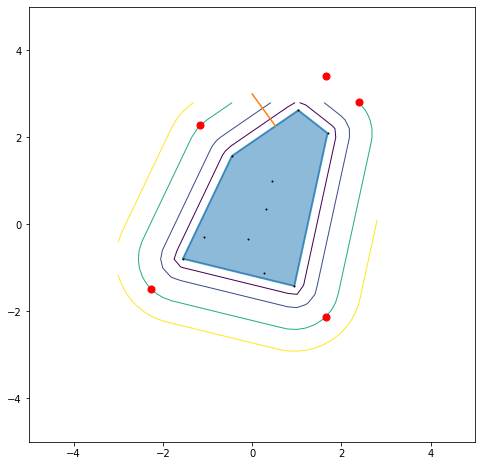

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
#ax.axis('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plot_hpoly_matplotlib(ax, hpoly)
#plot_ellipse(ax, he)
pt = np.array([0,3])
pt_proj = get_closest_point(pt, hpoly)
c = np.array([pt.T, pt_proj.T])
Z = plot_distance_fn(ax, hpoly, resolution=0.2)
plt.plot(c[:,0], c[:,1])
plt.scatter(pts[:,0], pts[:,1], s =1, c = 'k')
ax.scatter(supports[:, 0], supports[:,1], s = 50, c = 'r')
points_on_boundary = vpoly_min.vertices().T